# Max Electron Energy

The purpose of this notebook is to find the highest energy of the electrons fired directly toward the MCP

In [1]:
import numpy as np
from image_analysis_tools import *
from data_analysis_tools import *
import os
import pandas as pd

%matplotlib inline

## Using currents

Extract all the data and put into a single frame

In [4]:
cur_dir = "E:\\EmissionEnergy_Data\\ThressholdExtraction\\currents\\07THz_A_0_V_1490_1370_s2_10\\"

os.chdir(cur_dir)
files = os.listdir()

analysis = AnalysisTools(cur_dir)
data = pd.DataFrame()
for file in files:
    data = data.append(analysis.get_data(file,ret=True))

For each position and each voltage setting the average

In [5]:
data_averaged = pd.DataFrame()
for pos in data.position.unique():
    for voltage in data.voltage_setting.unique():
        current = data.loc[(data.position == pos) & (data.voltage_setting == voltage)].current3.mean()
        data_averaged = data_averaged.append(pd.DataFrame([[pos, voltage, current]], columns=["position","voltage_setting","current"]))

data_averaged = data_averaged.fillna(0)

The background is then subtracted

In [6]:
bright = data_averaged.loc[data_averaged.position == 0]
dark = data_averaged.loc[data_averaged.position == 90]

currents = bright["current"] - dark["current"]
currents = currents.reset_index()

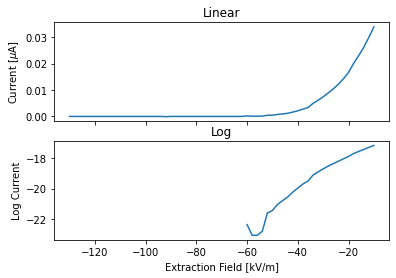

In [7]:
import matplotlib.pyplot as plt

current_values = currents.current.values
voltages = data_averaged.voltage_setting.unique()

voltages = -1500 - voltages

fig, ax = plt.subplots(2, sharex=True)
ax[0].set_title("Linear")
ax[0].plot(voltages, current_values*1e6)
ax[0].set_ylabel(f"Current [$\mu$A]")

ax[1].set_title("Log")
ax[1].set_xlabel("Extraction Field [kV/m]")
ax[1].set_ylabel("Log Current")

filtered_current = current_values[current_values > 0]
filtered_voltage = voltages[current_values > 0]

ax[1].plot(filtered_voltage, np.log(filtered_current))

## Using images

Start by importing and averaging all images with the same name

In [2]:
cur_dir = "E:\\EmissionEnergy_Data\\ThressholdExtraction\\images\\07THz_A_0_V_1490_1370_s2_10\\0\\"

images = ImageSeries(others=cur_dir)

Loaded 121 other images


In [3]:
reduced_set = "E:\\EmissionEnergy_Data\\ThressholdExtraction\\images\\07THz_A_0_V_1490_1370_s2_10\\reduced\\"

images.save_reduced_set(path=reduced_set)

Averaged images saved to folder:  E:\EmissionEnergy_Data\ThressholdExtraction\images\07THz_A_0_V_1490_1370_s2_10\reduced\
